In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gzip
import copy
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType
from pyspark.sql.functions import split

In [4]:
import pyspark.sql as sql
import pyspark.sql.functions as F
from pyspark import SparkContext

In [5]:
import os

def reload(filename, df, force_rewrite=False):
    '''Returns the dataframe stored in filename (located in data/saved), if it exists. Else, it writes the dataframe in filename and immediately reads it.'''
    filename = os.path.join('data', 'saved', filename)
    if os.path.exists(filename) and not force_rewrite :
        return spark.read.parquet(filename)
    else :
        df.write.mode('overwrite').parquet(filename)
        return spark.read.parquet(filename)

# Import the datasets 

**Instacart datasets** (provided) : https://www.instacart.com/datasets/grocery-shopping-2017 . After loading the datasets, we verified if there were any missing values

In [4]:
products = pd.read_csv('data/products.csv', sep=',')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [5]:
products.isnull().values.any()

False

In [6]:
aisles = pd.read_csv('data/aisles.csv', sep=',')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [7]:
aisles.isnull().values.any()

False

In [8]:
departments = pd.read_csv('data/departments.csv', sep=',')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [9]:
departments.isnull().values.any()

False

In [6]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
orders.isnull().values.sum()==orders['days_since_prior_order'].isnull().values.sum()

True

The missing values in _orders_ correspond to the date of "previous order", when it happens to be the first one.

In [12]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [13]:
history.isnull().values.any()

False

There are no unexpected missing values in any of the Instacart datasets.

**Create a dataset with all useful information gathered : products_litteral**

Add the names of the aisle and department in the _products_ dataset, instead of the ID, by merging the datasets :

In [14]:
products_litteral = pd.merge(pd.merge(products, aisles, on='aisle_id'), departments, on='department_id').drop(['aisle_id', 'department_id'], axis=1)
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


**Remove 'missing' values**

In [44]:
missing = products_litteral[(products_litteral.department =='missing') | (products_litteral.aisle=='missing')]
missing.head(20)

,product_id,product_name,aisle,department,number_of_orders


We can see many products don't have any name for the aisle and/or department

In [16]:
print("There are %d products with 'missing' aisle/department. This represent %0.1f%% of the products." %(missing.shape[0], missing.shape[0]/products_litteral.shape[0]*100))

There are 1258 products with 'missing' aisle/department. This represent 2.5% of the products.


The unlabelled products seem to come from many different categories, and represent a small fraction of our dataset. We decided to simply remove them.

In [17]:
products_litteral = products_litteral.drop(missing.index)

# First Statistical analysis

**Number of products per Aisle and Department**

Visualize the products per aisle and per department to detect any inconsistency

In [18]:
per_dpt=products_litteral[['product_id', 'department']].groupby('department').count().sort_values(by='product_id', ascending=False)

Text(0, 0.5, 'Departments')

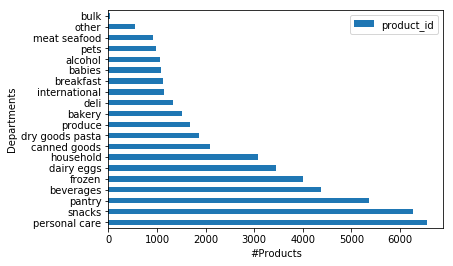

In [19]:
ax = per_dpt.plot(kind='barh')
ax.set_xlabel('#Products')
ax.set_ylabel('Departments')

In [20]:
per_dpt.head()

,product_id
department,
personal care,6563
snacks,6264
pantry,5371
beverages,4365
frozen,4007


The 'personal care' department has the most choice of products, jsut followed by the 'snacks' one.

In [21]:
per_aisle=products_litteral[['product_id', 'aisle']].groupby('aisle').count().sort_values(by='product_id', ascending=False)

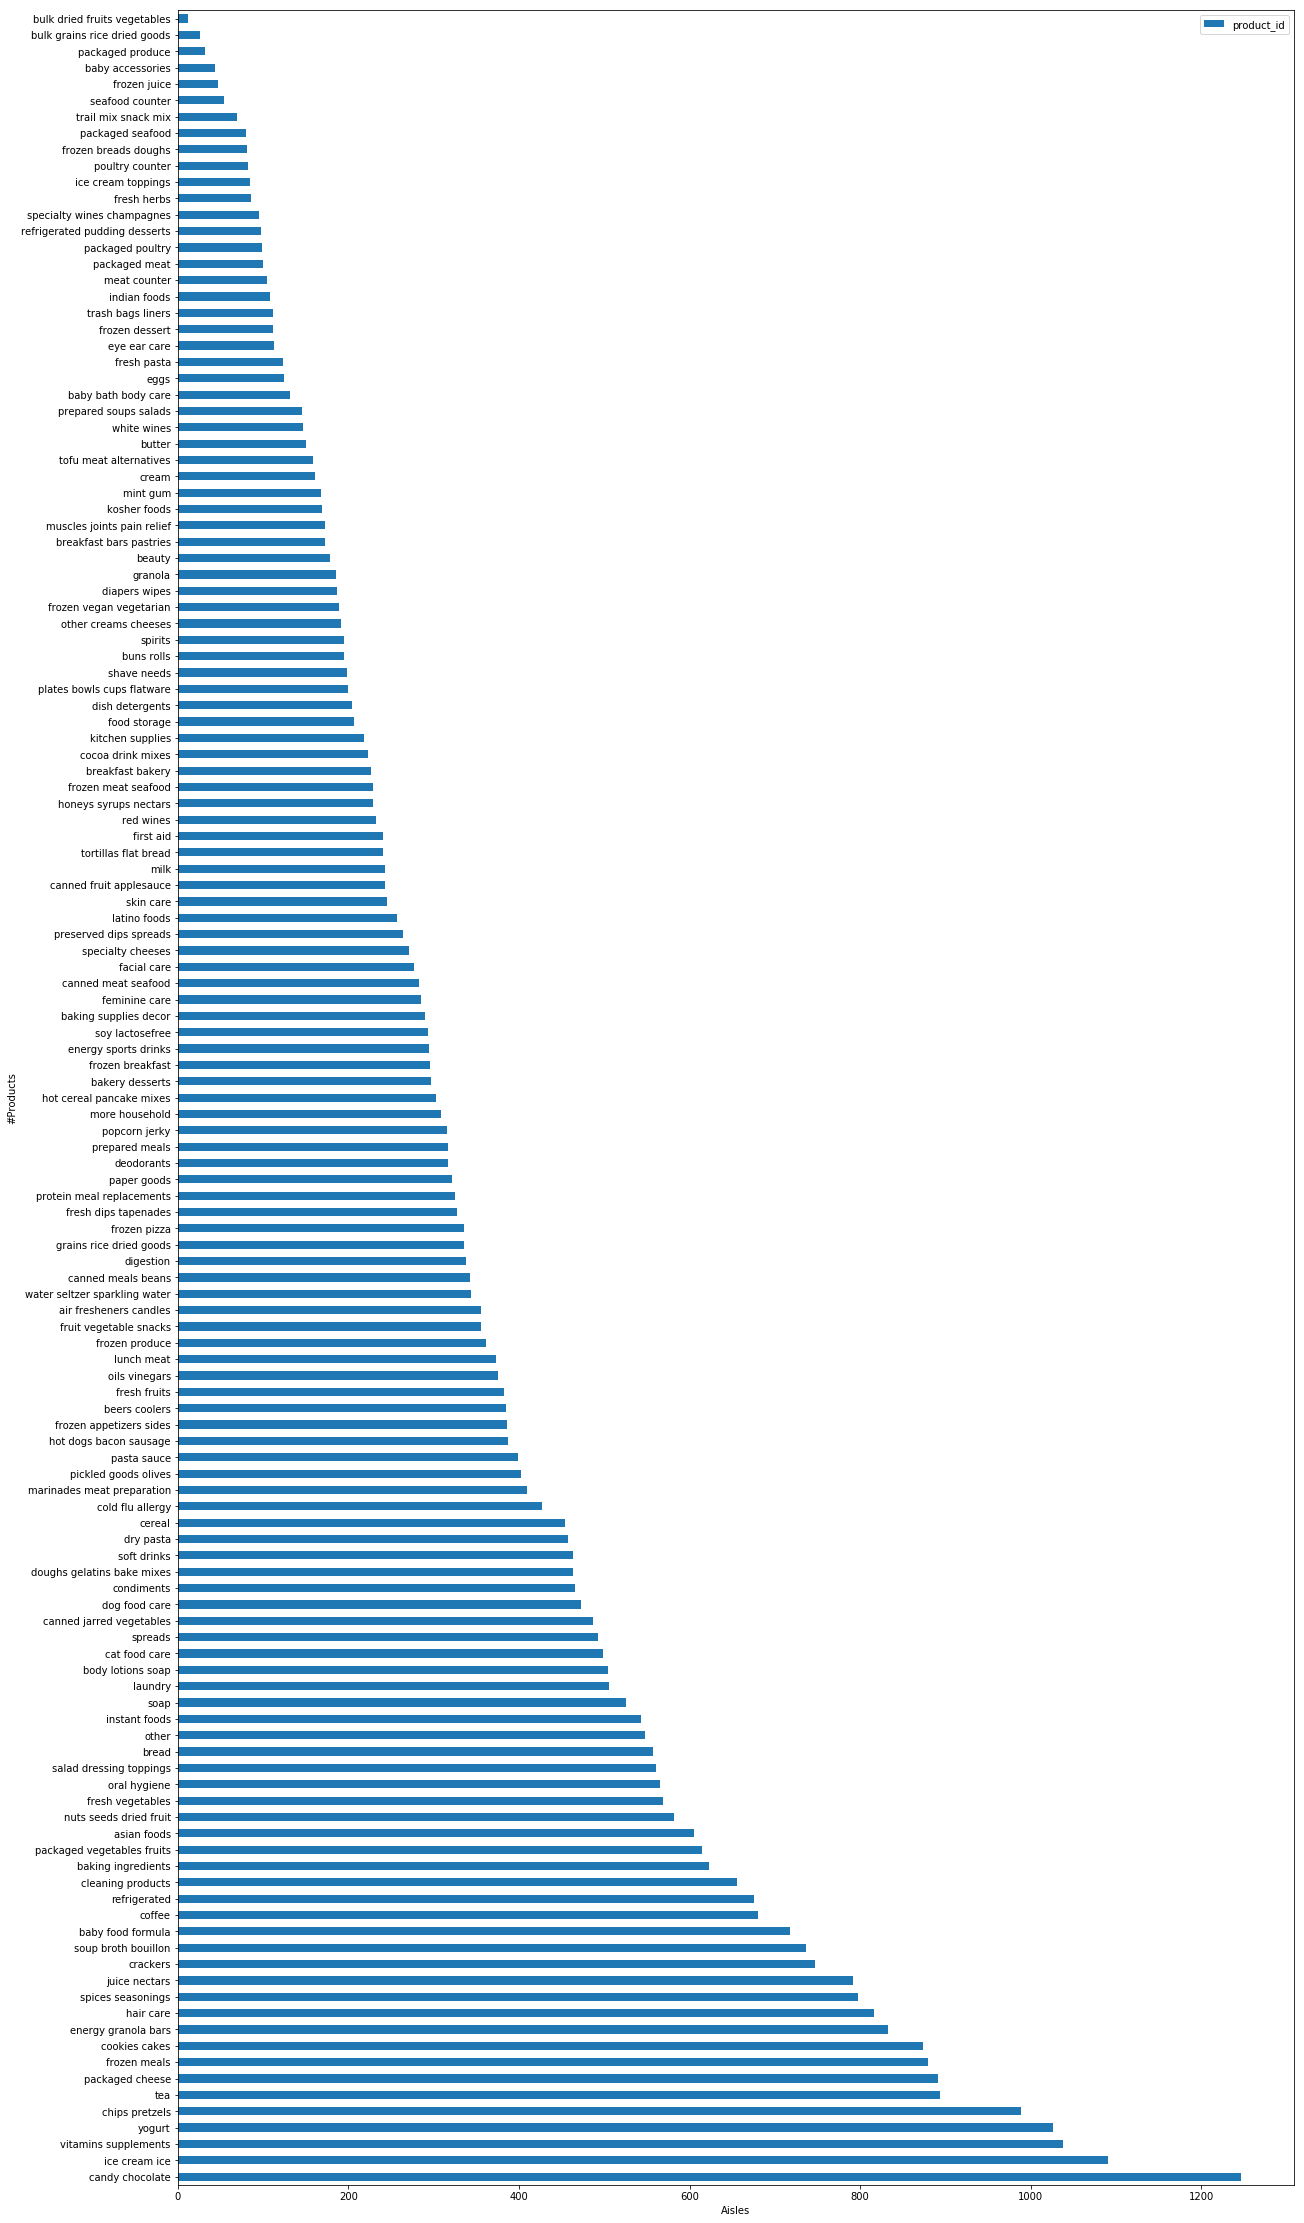

In [22]:
ax = per_aisle.plot(kind='barh', figsize=(20,40))
ax.set_ylabel('#Products')
ax.set_xlabel('Aisles')
plt.show()

In [23]:
per_aisle.head()

,product_id
aisle,
candy chocolate,1246
ice cream ice,1091
vitamins supplements,1038
yogurt,1026
chips pretzels,989


'Candy chocolate' and 'ice cream ice' contains the most numerous choice of products. We can see none of the 10 first aisles is in the 'Personal care' departement. Thus this department contains the most products because it contains a diverse choice of aisles of products, not one aisle with many products, as 'Snacks'.

**Number of orders**

Let's complete our 'useful' dataset with the informtion about the number of orders per product

In [24]:
number_of_order_per_product = history[['order_id','product_id']].groupby('product_id').count().sort_values(by='order_id', ascending=False)
number_of_order_per_product = number_of_order_per_product.rename(columns={"order_id" : "number_of_orders"})
number_of_order_per_product.head()

,number_of_orders
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [25]:
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [26]:
number_of_order_per_product.head()

,number_of_orders
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [27]:
products_litteral = pd.merge(products_litteral, number_of_order_per_product, on='product_id')
products_litteral.head()

,product_id,product_name,aisle,department,number_of_orders
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks,1852
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks,11
2,102,Danish Butter Cookies,cookies cakes,snacks,185
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks,97
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks,156


**Number of orders per product**

In [28]:
products_litteral.sort_values(by='number_of_orders', ascending=False).head()

,product_id,product_name,aisle,department,number_of_orders
42491,24852,Banana,fresh fruits,produce,472565
42399,13176,Bag of Organic Bananas,fresh fruits,produce,379450
42466,21137,Organic Strawberries,fresh fruits,produce,264683
41417,21903,Organic Baby Spinach,packaged vegetables fruits,produce,241921
42662,47209,Organic Hass Avocado,fresh fruits,produce,213584


Bananas are the most sold product.

Text(0, 0.5, 'Departments')

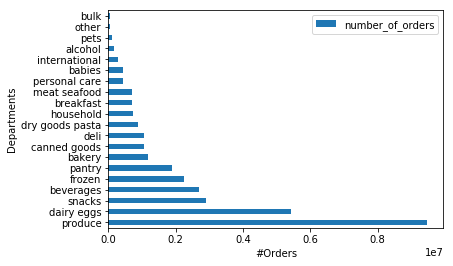

In [41]:
order_by_department = products_litteral[['department', 'number_of_orders']].groupby('department').sum().sort_values(by='number_of_orders', ascending=False).head(20)
ax = order_by_department.plot(kind='bar')
ax.set_ylabel('#Orders')
ax.set_xlabel('Departments')

Text(0.5, 0, 'Aisles')

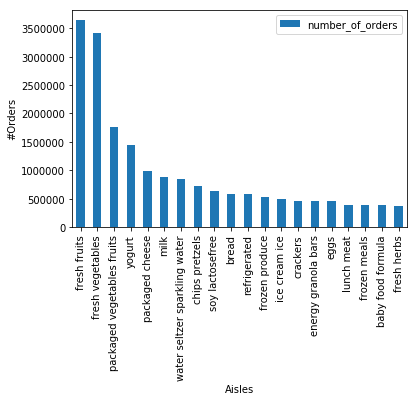

In [43]:
order_by_aisle = products_litteral[['aisle', 'number_of_orders']].groupby('aisle').sum().sort_values(by='number_of_orders', ascending=False).head(20)
ax = order_by_aisle.plot(kind='bar')
ax.set_ylabel('#Orders')
ax.set_xlabel('Aisles')

Produce, followed by eggs are the departments with most sales. For the aisles, it is fresh fruits and vegetables. Interestingly, snacks, which is the aisle with most choice of products, is only the third in number of sales.

**Timing of orders**

In [46]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [61]:
days_of_orders = orders[['order_id', 'order_dow']].groupby('order_dow').count()
days_of_orders = days_of_orders.rename(columns={"order_id" : "number_of_orders"})
days_of_orders

,number_of_orders
order_dow,
0,600905
1,587478
2,467260
3,436972
4,426339
5,453368
6,448761


In [68]:
days_of_orders.index = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

_Est ce que 0 correspond a Lundi ou Dimanche ??? On pourra le changer dans le dataset complet quand on sera surs ^^ ._

Text(0, 0.5, '#Orders')

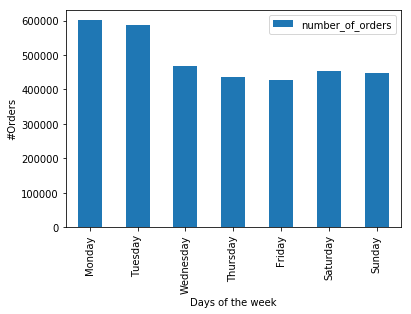

In [71]:
ax = days_of_orders.plot(kind='bar')
ax.set_xlabel('Days of the week')
ax.set_ylabel('#Orders')

Text(0, 0.5, '#Orders')

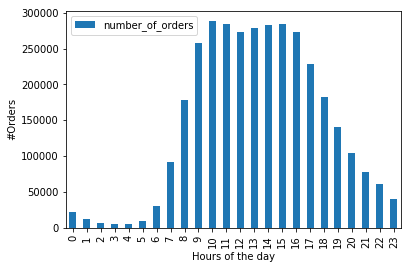

In [75]:
hours_of_orders = orders[['order_id', 'order_hour_of_day']].groupby('order_hour_of_day').count()
hours_of_orders = hours_of_orders.rename(columns={"order_id" : "number_of_orders"})
ax = hours_of_orders.plot(kind='bar')
ax.set_xlabel('Hours of the day')
ax.set_ylabel('#Orders')

People tend to order during working hours (between 8am and 20pm), and at the beginning of the week (Monday and Tuesday).

**Multiple orders**

Text(0, 0.5, '#Orders')

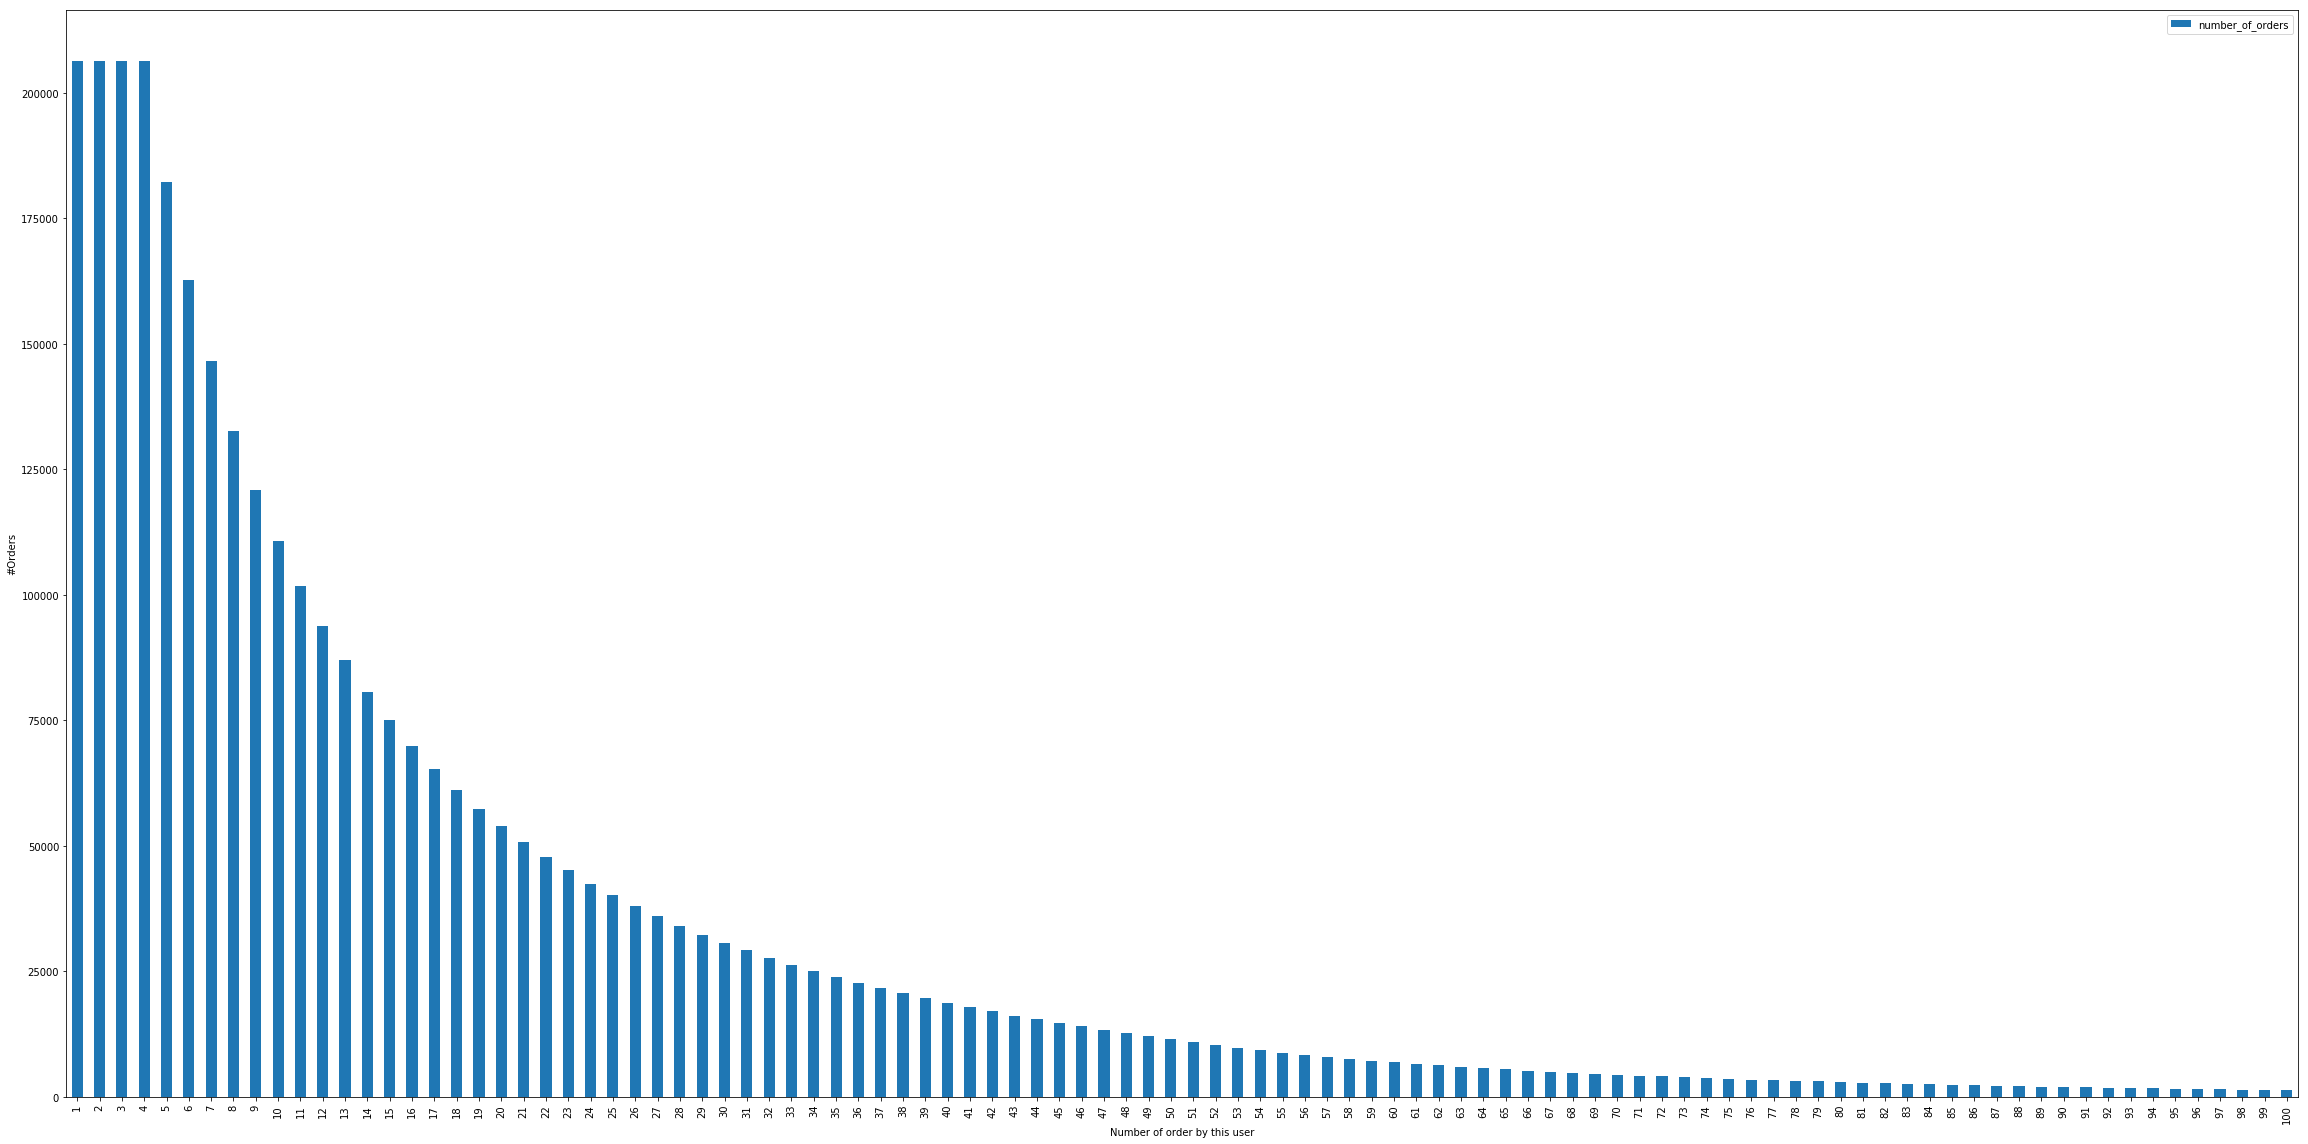

In [7]:
number_of_orders = orders[['order_id', 'order_number']].groupby('order_number').count()
number_of_orders = number_of_orders.rename(columns={"order_id" : "number_of_orders"})
ax = number_of_orders.plot(kind='bar', figsize=(40,20))
ax.set_xlabel('Number of order by this user')
ax.set_ylabel('#Orders')

Most of the orders are just first orders.

In [8]:
max_orders = orders[['user_id', 'order_number']].groupby('user_id').max()
max_orders = max_orders.rename(columns={"order_number" : "max_orders"})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002620736AB38>]],
      dtype=object)

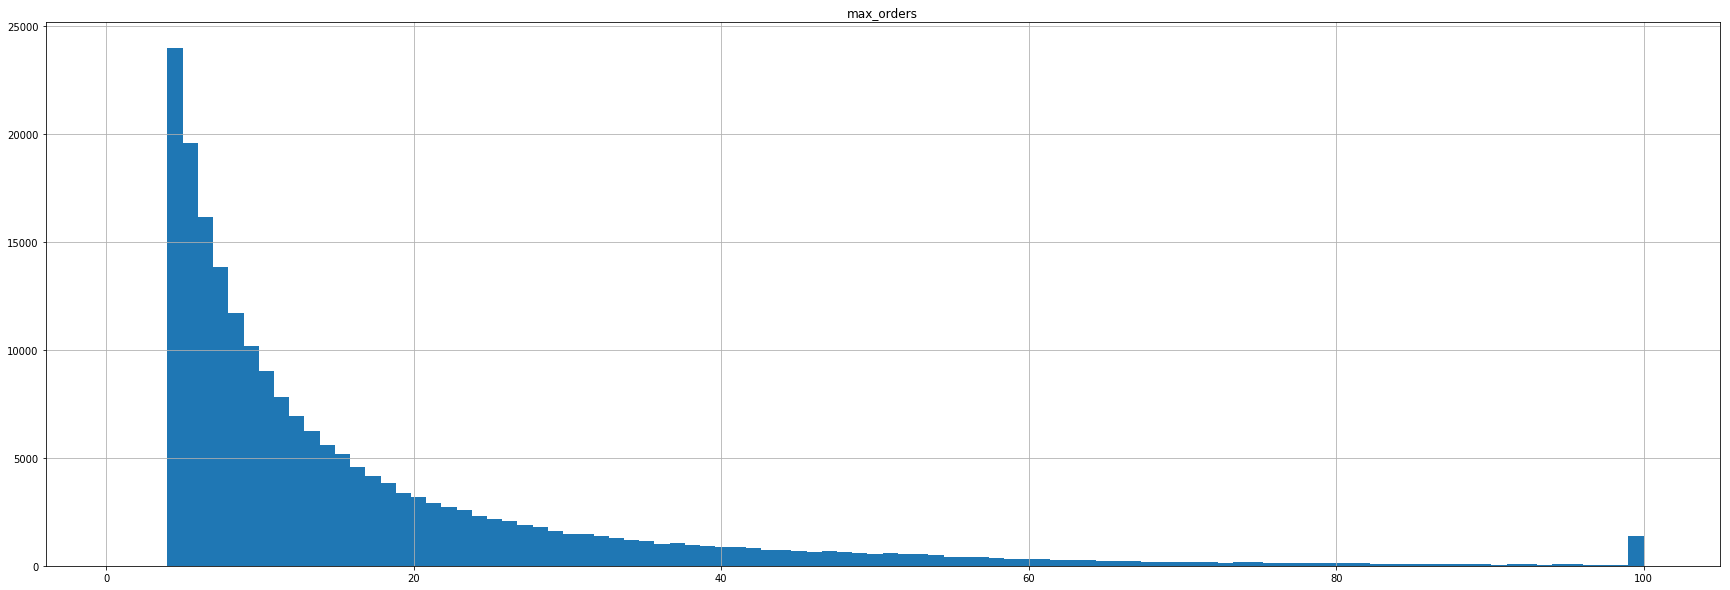

In [26]:
m = int(max_orders.max())
max_orders.hist(range=(1, m), bins = m, figsize=(30,10))

Most of the consumers only order 4 times. None of them less _(probably just data not shown)???_ , and the distribution is then logarithmic We can see a high pic at 100 orders, which probably correspond to "100 and more". 

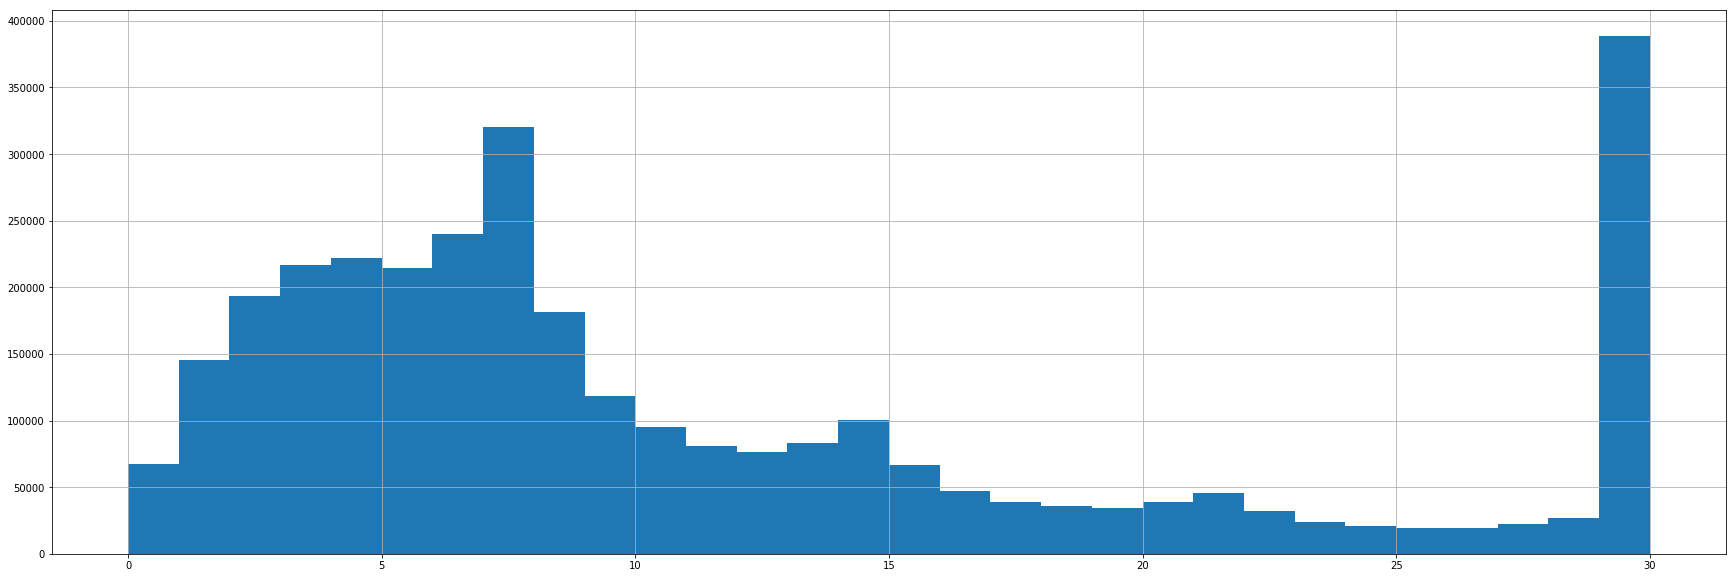

In [33]:
m = int(orders['days_since_prior_order'].max())
orders['days_since_prior_order'].hist(bins = m, figsize=(30,10))

We can see a high pick in "30 days", which probably corresponds to "30 and more", thus unregular users. Otherwise, most consumer reorder within 10 days and we can see a pick in 7 days. This means many users order at the same day of he week.

# Try on Amazon dataset

**Amazon dataset** : _metadata_ and _reviews_ of Grocery and Gourmet Food products : https://cseweb.ucsd.edu/~jmcauley/datasets.html?fbclid=IwAR39s5O83nqUYkRBD4jol3OFu0FmcH-4dCzUtSjutOsmSd9LMZOHSGGtNxw#amazon_reviews


In [216]:
products_litteral.head()

,product_id,product_name,aisle,department,number_of_orders
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks,1852
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks,11
2,102,Danish Butter Cookies,cookies cakes,snacks,185
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks,97
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks,156


In [217]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [218]:
Amazon_meta = spark.read.json("data/meta_Grocery_and_Gourmet_Food.json.gz")
#Amazon_meta = reload('Amazon_meta.parquet', Amazon_meta)
Amazon_meta.show(2)

+--------------------+--------------------+----------+--------------+--------------------+----+--------------------+-------+-------+----+--------------------+--------+------+--------------------+------------+-----+--------------------+
|            also_buy|           also_view|      asin|         brand|            category|date|         description|details|feature| fit|               image|main_cat| price|                rank|similar_item|tech1|               title|
+--------------------+--------------------+----------+--------------+--------------------+----+--------------------+-------+-------+----+--------------------+--------+------+--------------------+------------+-----+--------------------+
|                null|[B0000D9MYM, B000...|0681727810|Ariola Imports|[Grocery & Gourme...|null|[BEEMSTER GOUDA C...|   null|   null|null|                null| Grocery|$41.91|165,181inGroceryG...|        null| null|Beemster Gouda - ...|
|[B01898YHXK, B01B...|                null|0853347867|  

In [219]:
Amazon_meta_light = Amazon_meta.drop('also_view','description','details','feature','fit', 'image','similar_item', 'tech1')
Amazon_meta_light = reload('Amazon_meta_light.parquet', Amazon_meta_light)

In [220]:
Amazon_meta_light.printSchema()

root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: string (nullable = true)
 |-- main_cat: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- title: string (nullable = true)



In [221]:
for row in Amazon_meta_light.take(20):
    print(row.category, 'for main_cat', row.main_cat)

['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda'] for main_cat Grocery
['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol'] for main_cat Grocery
['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers'] for main_cat Amazon Home
['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers'] for main_cat Amazon Home
['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers'] for main_cat Amazon Home
['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers'] for main_cat Amazon Home
['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers'] for main_cat Amazon Home
['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorati

In [222]:
for row in Amazon_meta_light.filter(udf(lambda x: x=='Iguana Mean Green Jalapeno Pepper Sauce, 5 oz bottle', sql.types.BooleanType())('title')).take(10):
    print(row.title, row.category, sep=' | ')

Iguana Mean Green Jalapeno Pepper Sauce, 5 oz bottle | ['Grocery & Gourmet Food', 'Sauces, Gravies & Marinades', 'Hot Sauce']


In [223]:
Amazon_reviews = spark.read.json("data/Grocery_and_Gourmet_Food.json.gz")
#Amazon_reviews = reload('Amazon_reviews.parquet', Amazon_reviews)
Amazon_reviews.show(2)

+----------+-----+-------+--------------------+-----------+--------------+------------+-----+--------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|reviewerName|style|       summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+------------+-----+--------------+--------------+--------+----+
|1888861614| null|    5.0|Very pleased with...| 06 4, 2013| ALP49FBWT4I7V|        Lori| null|       Love it|    1370304000|    true|null|
|1888861614| null|    4.0|Very nicely craft...|05 23, 2014|A1KPIZOCLB9FZ8|  BK Shopper| null|Nice but small|    1400803200|    true|null|
+----------+-----+-------+--------------------+-----------+--------------+------------+-----+--------------+--------------+--------+----+
only showing top 2 rows



In [224]:
Amazon_reviews.printSchema()

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Design:: string (nullable = true)
 |    |-- Display Height:: string (nullable = true)
 |    |-- Edition:: string (nullable = true)
 |    |-- Flavor Name:: string (nullable = true)
 |    |-- Flavor:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Item Display Weight:: string (nullable = true)
 |    |-- Item Package Quantity:: string (nullable = true)
 |    |-- Material Type:: string (nullable = true)
 |    |-- Material:: string (nullable = true)
 |    |-- Number of Items:: string (nullable = true)
 |    |-- Package Quantity:: string (nulla

**Connect the two datasets**

Use only a sample of the all Amazon datasets for the tests

In [225]:
Amazon1=Amazon_meta_light.sample(False, 0.001)

In [226]:
Amazon1.count() #number of rows in this test sample Amazon dataset

246

In [227]:
products_lit_spark = spark.createDataFrame(products_litteral) #convert Instacart panda df to spark df
products_lit_spark = reload('products_lit_spark.parquet', products_lit_spark)

In [228]:
products_lit_spark.count()

48422

In [229]:
products_lit_spark.show()

+----------+--------------------+-----+----------+----------------+
|product_id|        product_name|aisle|department|number_of_orders|
+----------+--------------------+-----+----------+----------------+
|     36629|Lucky Irish Break...|  tea| beverages|               9|
|     36638|Scottish Breakfas...|  tea| beverages|              85|
|     36694|White Tea Unsweet...|  tea| beverages|              28|
|     36771|    Twig Kukicha Tea|  tea| beverages|              62|
|     36890|Healthy Cycle Her...|  tea| beverages|              18|
|     36891|Superfruit Pomegr...|  tea| beverages|               5|
|     36902|RX Stress Herbal ...|  tea| beverages|              22|
|     36951|   Organic White Tea|  tea| beverages|               6|
|     37071|Herbal Tea, Caffe...|  tea| beverages|              41|
|     37102|Honey Lemon Ginse...|  tea| beverages|              18|
|     37118|Peach, Natural Bl...|  tea| beverages|              24|
|     37154|Herbal Tea, Lemon...|  tea| beverage

In [230]:
for row in Amazon_meta_light.take(10):
    print(row.title)
print()
for row in products_lit_spark.take(10):
    print(row.product_name)

Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs
Trim Healthy Mama Xylitol
Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter
Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter
Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter
Letter J - Swarovski Crystal Monogram Wedding Cake Topper Letter
1 X Fully Covered in Crystal Monogram Wedding Cake Topper Letter - Letter O
Fully Covered in Crystal Monogram Wedding Cake Topper Letter - Letter R
Letter L - Swarovski Crystal Monogram Wedding Cake Topper Letter
Fully Covered in Crystal Monogram Wedding Cake Topper Letter - Letter C

Lucky Irish Breakfast Pot Of Gold Tea
Scottish Breakfast Tea
White Tea Unsweetened Hint O'Mint
Twig Kukicha Tea
Healthy Cycle Herbal Tea Bags, Caffeine Free
Superfruit Pomegranate Green Tea
RX Stress Herbal Iced Tea
Organic White Tea
Herbal Tea, Caffeine Free, True Blueberry
Honey Lemon Ginseng Green Tea Bags


**first try** Try to join by the name of the products 

In [231]:
df = Amazon1.join(products_lit_spark, col('title')== col('product_name'))

In [232]:
df.count()

0

Not working, never more than a few fits (1 or 2) over the 2876 Amazon reviews and 49688 Instacart products

**second try** Try to join on : if Instacart name is in the Amazon title

In [233]:
df = Amazon1.join(products_lit_spark, col('title').contains(col('product_name')))

In [234]:
df.show(10)

+--------------------+----------+----------+--------------------+----+--------------------+----------------+--------------------+--------------------+----------+--------------------+--------------------+----------+----------------+
|            also_buy|      asin|     brand|            category|date|            main_cat|           price|                rank|               title|product_id|        product_name|               aisle|department|number_of_orders|
+--------------------+----------+----------+--------------------+----+--------------------+----------------+--------------------+--------------------+----------+--------------------+--------------------+----------+----------------+
|                null|B016S9JGSS|  Ringtons|[Grocery & Gourme...|null|             Grocery|           $7.95|106,471inGroceryG...|Ringtons Tea, Ken...|     40059|            Tea Bags|                 tea| beverages|               4|
|                null|B01ENEWCB8|NUTRIHERBS|[Grocery & Gourme...|null|He

It is impossible to link by name because actually, the Instacart dataset doesn't reference precise products but generic names (no brands)

In [235]:
for row in df.take(10):
    print(row.product_name, 'paired with', row.title)

Tea Bags paired with Ringtons Tea, Kenyan Gold, 50 Black Tea Bags
Tea Bags paired with Cayenne Pepper Tea Bags Afternoon Tea Blend With A Hint Of Cinnamon 50 Pack
1 Liter paired with evian Natural Spring Water (One Case of 12 Individual Bottles, Each Bottle is 1 Liter) Naturally Filtered Spring Water in Large Bottles
Natural Spring Water paired with evian Natural Spring Water (One Case of 12 Individual Bottles, Each Bottle is 1 Liter) Naturally Filtered Spring Water in Large Bottles
Spring Water paired with evian Natural Spring Water (One Case of 12 Individual Bottles, Each Bottle is 1 Liter) Naturally Filtered Spring Water in Large Bottles
Mineral Water paired with Perrier Sparkling Natural Mineral Water, Lime, 33.8-ounce Plastic Bottles (Pack of 12)
Water paired with Starkist Chunk Light Tuna in Water, 12-Ounce Cans (Pack of 24)
Water paired with Evamor - Water Artsn 12Pk20 Oz
Water paired with Perrier Sparkling Natural Mineral Water, Lime, 33.8-ounce Plastic Bottles (Pack of 12)
Wat

In [236]:
products_litteral[products_litteral.product_name == 'Tea Bags'].head()

,product_id,product_name,aisle,department,number_of_orders
12363,40059,Tea Bags,tea,beverages,4


In [237]:
for row in Amazon1.filter(udf(lambda x: x=='Iguana Mean Green Jalapeno Pepper Sauce, 5 oz bottle', sql.types.BooleanType())('title')).take(10):
    print(row.title, row.category, sep=' | ')

Iguana Mean Green Jalapeno Pepper Sauce, 5 oz bottle | ['Grocery & Gourmet Food', 'Sauces, Gravies & Marinades', 'Hot Sauce']


There are too many lines : as the Instacart title is not specific enough, it links many Amazon product

In [238]:
df.count()

433

In [239]:
df.dropDuplicates(['title']).show(2)

+--------------------+----------+-------------+--------------------+----+--------+------+--------------------+--------------------+----------+-------------+-----------------+----------+----------------+
|            also_buy|      asin|        brand|            category|date|main_cat| price|                rank|               title|product_id| product_name|            aisle|department|number_of_orders|
+--------------------+----------+-------------+--------------------+----+--------+------+--------------------+--------------------+----------+-------------+-----------------+----------+----------------+
|[B003GYRNLQ, B00G...|B00B5CP0O8|        Royce|[Grocery & Gourme...|null| Grocery|$40.55|226,743inGroceryG...|Royce Pure Chocol...|     19567|        White|specialty cheeses|dairy eggs|              12|
|                null|B00AAXJ7ZG|Betty Crocker|[Grocery & Gourme...|null| Grocery|$13.99|253,128inGroceryG...|Betty Crocker Pum...|      5052|Pumpkin Spice|spices seasonings|    pantry|   

In [240]:
df.dropDuplicates(['title']).count()

193

Weird associations (still because of the non specific Instacart title). I think that is because I have a little Amazon sample, otherwise it would just drop almost every row

**Third try** : only join the categories 

In [241]:
Amazon3 = Amazon1.select('title','category')

In [242]:
Amazon3_cat_exploded = Amazon3.select('title', explode('category').alias('category'))
Amazon3_cat_exploded = reload('Amazon3_cat_exploded.parquet', Amazon3_cat_exploded)

In [243]:
Amazon3_cat_exploded.show(5)

+--------------------+--------------------+
|               title|            category|
+--------------------+--------------------+
|Maizena Corn Star...|Grocery & Gourmet...|
|Maizena Corn Star...|    Cooking & Baking|
|Maizena Corn Star...|          Thickeners|
|Gourmet Peanut Br...|Grocery & Gourmet...|
|Gourmet Peanut Br...|           Beverages|
+--------------------+--------------------+
only showing top 5 rows



In [244]:
Amazon3_cat_exploded.printSchema()
products_lit_spark.printSchema()

root
 |-- title: string (nullable = true)
 |-- category: string (nullable = true)

root
 |-- product_id: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle: string (nullable = true)
 |-- department: string (nullable = true)
 |-- number_of_orders: long (nullable = true)



In [245]:
df3 = Amazon3_cat_exploded.join(products_lit_spark, products_lit_spark.aisle==Amazon3_cat_exploded.category)

In [246]:
df3.count()

0

Not the same exact names of categories, so nto working

In [247]:
len(Amazon3_cat_exploded.select('category').distinct().collect())

216

There are too many categories for us to pair them by hand.

**fourth try** : joindre les categories Amazon et les aisles Instacart avec des mots en commun

In [248]:
#separate Instacart aisle name, because names are too specific (to match cookies cakes with snack cakes for instance)
split_col = split(products_lit_spark['aisle'], ' ')
split_aisle = products_lit_spark.withColumn('aisle1', split_col.getItem(0))
split_aisle = split_aisle.withColumn('aisle2', split_col.getItem(1))
split_aisle = reload('split_aisle.parquet', split_aisle)
split_aisle.show()

+----------+--------------------+-----+----------+----------------+------+------+
|product_id|        product_name|aisle|department|number_of_orders|aisle1|aisle2|
+----------+--------------------+-----+----------+----------------+------+------+
|     36629|Lucky Irish Break...|  tea| beverages|               9|   tea|  null|
|     36638|Scottish Breakfas...|  tea| beverages|              85|   tea|  null|
|     36694|White Tea Unsweet...|  tea| beverages|              28|   tea|  null|
|     36771|    Twig Kukicha Tea|  tea| beverages|              62|   tea|  null|
|     36890|Healthy Cycle Her...|  tea| beverages|              18|   tea|  null|
|     36891|Superfruit Pomegr...|  tea| beverages|               5|   tea|  null|
|     36902|RX Stress Herbal ...|  tea| beverages|              22|   tea|  null|
|     36951|   Organic White Tea|  tea| beverages|               6|   tea|  null|
|     37071|Herbal Tea, Caffe...|  tea| beverages|              41|   tea|  null|
|     37102|Hone

In [249]:
#see if aisle words are included in the category name Amazon 
df4 = Amazon3_cat_exploded.select('category').distinct().join(split_aisle.select('aisle1', 'aisle2').distinct(), col('category').contains(col('aisle1')) | col('category').contains(col('aisle2')))
df4 = reload('df4.parquet', df4)

In [250]:
df4.show(20)
for row in df4.take(20):
    print(row.category)

+--------------------+------+------+
|            category|aisle1|aisle2|
+--------------------+------+------+
|Mixed Spices & Se...|   ice| cream|
|   Deli-Sliced Meats|   ice| cream|
|       Grains & Rice|   ice| cream|
|Herbs, Spices & S...|   ice| cream|
|              Juices|   ice| cream|
|Rice Cakes, Chips...|   ice| cream|
|Dried Beans, Grai...|   ice| cream|
|           Rice Milk|   ice| cream|
|                Rice|   ice| cream|
|            Licorice|   ice| cream|
|     Sparkling Juice|   ice| cream|
|Packaged & Sliced...|   ice| cream|
|         Fruit Juice|   ice| cream|
|Single Herbs & Sp...|   ice| cream|
|      Flavored Water|   red| wines|
|Canned, Jarred & ...|   red| wines|
|Powdered Drink Mixes|   red| wines|
|            Flavored|   red| wines|
|       Flavored Salt|   red| wines|
|Powdered Drink Mi...|   red| wines|
+--------------------+------+------+
only showing top 20 rows

Mixed Spices & Seasonings
Deli-Sliced Meats
Grains & Rice
Herbs, Spices & Seasonings
J

ça ne marche pas du tout : il faut faire matcher les mots entier, pas juste "contains" !

In [257]:
#avec pyspark, necessité de passer par les fonctions python udf
mots_udf = udf(lambda x: re.compile("\\W+").split(x), sql.types.ArrayType(sql.types.StringType()))

In [262]:
Amazon4 = Amazon3_cat_exploded.withColumn('mots', mots_udf(Amazon3_cat_exploded.category))


In [263]:
Amazon4.show(5)

+--------------------+--------------------+--------------------+
|               title|            category|                mots|
+--------------------+--------------------+--------------------+
|Maizena Corn Star...|Grocery & Gourmet...|[Grocery, Gourmet...|
|Maizena Corn Star...|    Cooking & Baking|   [Cooking, Baking]|
|Maizena Corn Star...|          Thickeners|        [Thickeners]|
|Gourmet Peanut Br...|Grocery & Gourmet...|[Grocery, Gourmet...|
|Gourmet Peanut Br...|           Beverages|         [Beverages]|
+--------------------+--------------------+--------------------+
only showing top 5 rows



_Obviously, this fucntion doesn't work, but why ?? seems like something is "too big"..._